# Ground - State: Heisenberg model

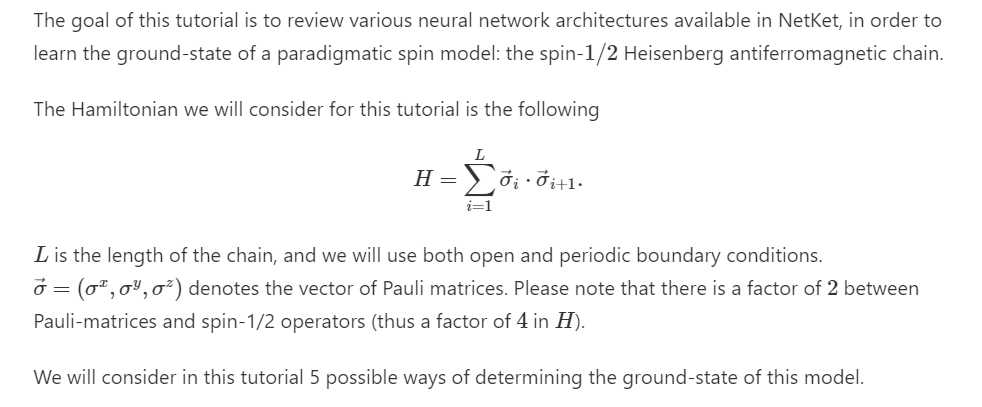

In [1]:
import netket as nk
import numpy as np
import matplotlib.pyplot as plt
import time
import json

print("Import Successful")

/home/ashuworld/pythonenv/lib/python3.9/site-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(


Import Successful


In [2]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"

# Defining the Hamiltonian

We define the antiferromagnetic heisenberg chain lattice with L=22 

In [3]:
# Define 1D chain
L = 22
g= nk.graph.Hypercube(length=L, n_dim=1, pbc= True)

In [4]:
g

Lattice(
    n_nodes=22,
    extent=[22],
    basis_vectors=
        [[1.]],
    site_offsets=
        [[0.]],
)

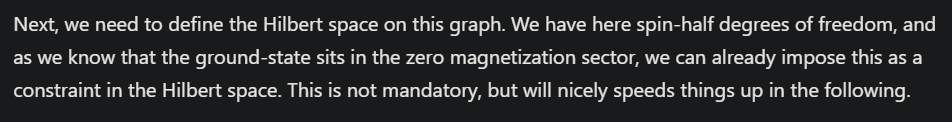

In [5]:
# Hilbert Space
hi= nk.hilbert.Spin(s=0.5,total_sz=0,N=g.n_nodes) 
# total_sz=0 : to impose gs condition

In [6]:
hi

Spin(s=1/2, total_sz=0, N=22)

In [7]:
# Calling heisenberg hamiltonian
ha= nk.operator.Heisenberg(hilbert=hi,graph=g)
# predefined in nk and uses pauli matrices

In [8]:
ha


Heisenberg(J=1.0, sign_rule=True; dim=22)

# Exact diagonalization (as a testbed)

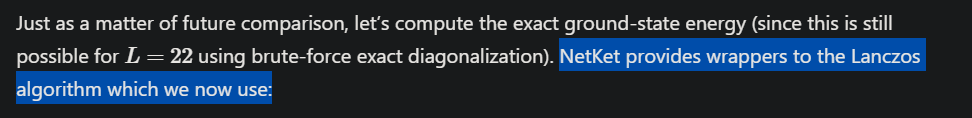

In [9]:
# computing the gs energy
evals= nk.exact.lanczos_ed(ha,compute_eigenvectors=False)

In [10]:
exact_gs_energy= evals[0]
print('Exact gs energy is E0= ',exact_gs_energy)

Exact gs energy is E0=  -39.147522607062804


In [11]:
evect= nk.exact.lanczos_ed(ha,compute_eigenvectors=True)

In [12]:
evect[1]

array([[-9.55404436e-17],
       [-1.37057076e-15],
       [-8.52861164e-15],
       ...,
       [-8.52990883e-15],
       [-1.37034159e-15],
       [-9.56896148e-17]])

In [13]:
evect[1].shape

(705432, 1)

# Jastrow Ansatz

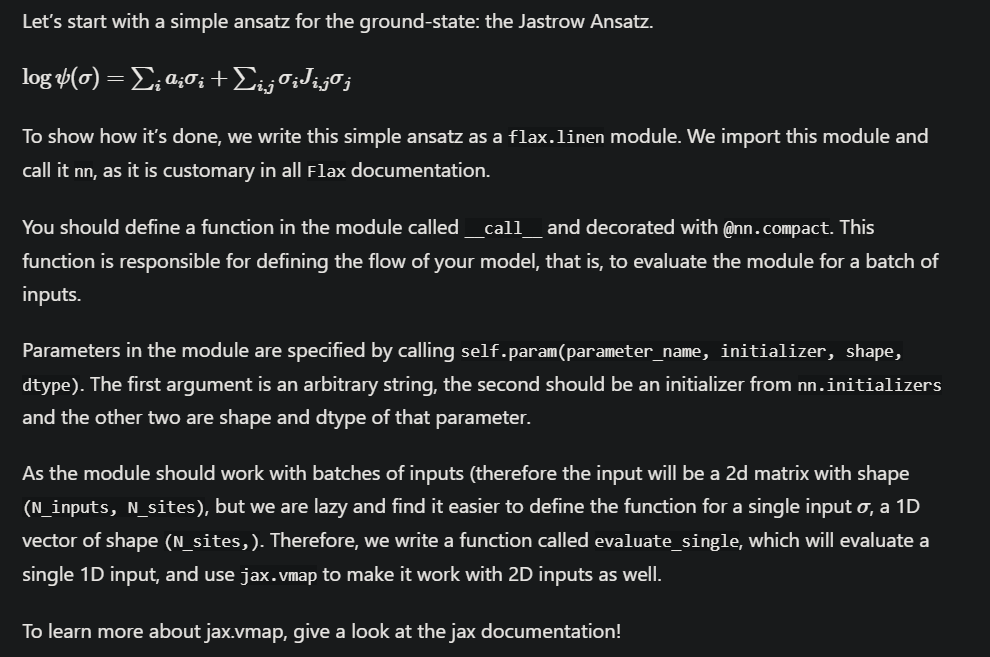

In [14]:
import flax.linen as nn
import jax.numpy as jnp
import jax

class Jastrow(nn.Module):
    @nn.compact
    def __call__(self, x):
        # sometimes we call this function with a 1D input, sometimes with a 2D.
        # We promote all inputs to 2D to make the following code simpler.
        x = jnp.atleast_2d(x)
        # We vmap along the 0-th axis of the input
        # This will automatically convert a function working on vectors to one working
        # on matrices.
        return jax.vmap(self.evaluate_single, in_axes=(0))(x)
        
    def evaluate_single(self, x):
        # We create the parameter v, which is a vector of length N_sites 
        v_bias = self.param(
            "visible_bias", nn.initializers.normal(), (x.shape[-1],), complex
        )
    
        # The Jastrow matrix is a N_sites x N_sites complex-valued matrix
        J = self.param(
            "kernel", nn.initializers.normal(), (x.shape[-1],x.shape[-1]), complex
        )
        
        # In python @ symbolises matrix multiplication
        return x.T@J@x + jnp.dot(x, v_bias)

In [15]:
ma = Jastrow()
print(ma)

Jastrow()


In [16]:
# Build the sampler
sa = nk.sampler.MetropolisExchange(hilbert=hi,graph=g)

# Optimizer
op = nk.optimizer.Sgd(learning_rate=0.1)

# Stochastic Reconfiguration
sr = nk.optimizer.SR(diag_shift=0.1)

# The variational state
vs = nk.vqs.MCState(sa, ma, n_samples=1000)

# The ground-state optimization loop
gs = nk.VMC(
    hamiltonian=ha,
    optimizer=op,
    preconditioner=sr,
    variational_state=vs)

start = time.time()
gs.run(300, out='Jastrow')
end = time.time()

print('### Jastrow calculation')
print('Has',nk.jax.tree_size(vs.parameters),'parameters')
print('The Jastrow calculation took',end-start,'seconds')

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/home/ashuworld/pythonenv/lib/python3.9/site-packages/netket/vqs/mc/mc_state/state.py:58: UserWarning: n_samples=1000 (1000 per MPI rank) does not divide n_chains=16, increased to 1008 (1008 per MPI rank)
  warnings.warn(
100%|████████████████████████████| 300/300 [00:51<00:00,  5.85it/s, Energy=-39.139+0.000j ± 0.016 [σ²=0.248, R̂=1.0086]]

### Jastrow calculation
Has 506 parameters
The Jastrow calculation took 59.5877423286438 seconds


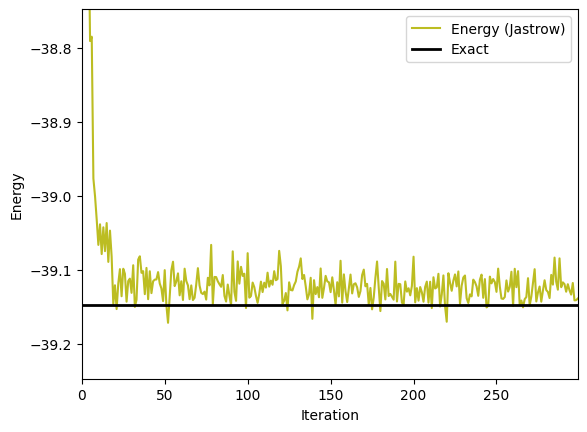

In [17]:
# import the data from log file
data_Jastrow=json.load(open("Jastrow.log"))
   
iters_Jastrow = data_Jastrow["Energy"]["iters"]
energy_Jastrow = data_Jastrow["Energy"]["Mean"]["real"]

fig, ax1 = plt.subplots()
ax1.plot(iters_Jastrow, energy_Jastrow, color='C8', label='Energy (Jastrow)')
ax1.set_ylabel('Energy')
ax1.set_xlabel('Iteration')
plt.axis([0,iters_Jastrow[-1],exact_gs_energy-0.1,exact_gs_energy+0.4])
plt.axhline(y=exact_gs_energy, xmin=0,
                xmax=iters_Jastrow[-1], linewidth=2, color='k', label='Exact')
ax1.legend()
plt.show()

# Learning with Feed Forward Neural Networks

In [25]:
class Model(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=2*x.shape[-1], param_dtype=np.complex128,
                     kernel_init=nn.initializers.normal(stddev=0.1), 
                     bias_init=nn.initializers.normal(stddev=0.1))(x)
        x = nk.nn.activation.log_cosh(x)
        return jax.numpy.sum(x, axis=-1)
    
ffnn = Model()

sa = nk.sampler.MetropolisExchange(hi, graph=g)

# The variational state
vs = nk.vqs.MCState(sa, ffnn, n_samples=1000)

opt = nk.optimizer.Sgd(learning_rate=0.05)

# Stochastic Reconfiguration
sr = nk.optimizer.SR(diag_shift=0.1)

# The ground-state optimization loop
gs = nk.VMC(
    hamiltonian=ha,
    optimizer=opt,
    preconditioner=sr,
    variational_state=vs)


start = time.time()
gs.run(out='FF', n_iter=300)
end = time.time()

print('### Feed Forward calculation')
print('Has',vs.n_parameters,'parameters')
print('The Feed Forward calculation took',end-start,'seconds')

100%|████████████████████████████| 300/300 [02:53<00:00,  1.73it/s, Energy=-39.101-0.010j ± 0.020 [σ²=0.394, R̂=1.0120]]

### Feed Forward calculation
Has 1012 parameters
The Feed Forward calculation took 176.65173935890198 seconds


In [28]:
gs.energy

-39.101-0.010j ± 0.020 [σ²=0.394, R̂=1.0120]

In [39]:
def fitness_func(energy,energy_idx):
    error = -5.0 + energy
    fitness = 1.0/(error + 0.0001)
    return fitness

In [42]:
def genetic_opt(energy):
    ga_inst = ga.GA(num_generations= 100,
                   num_parents_mating= 10,
                   fitness_func=fitness_func,
                   sol_per_pop=20,
                   num_genes = 20)
    ga_inst.run()
    solution, solution_fitness,_ = ga_inst.best_solution()
    return solution

In [51]:
gs.energy.mean

Array(-39.10127848-0.00990711j, dtype=complex128)

In [43]:
optimizer = genetic_opt(gs.energy)

ValueError: The fitness function should return a number but the value [-0.15483881 -0.16701109 -0.13430906 -0.16228891 -0.13620909 -0.17621728
 -0.4657167  -0.33646134 -0.14871047 -0.11279452 -0.41597313 -0.12465056
 -0.14601522 -0.52696106 -0.24310533 -0.11198201 -0.16605021 -0.21582201
 -0.11724411 -0.11754535] of type <class 'numpy.ndarray'> found.

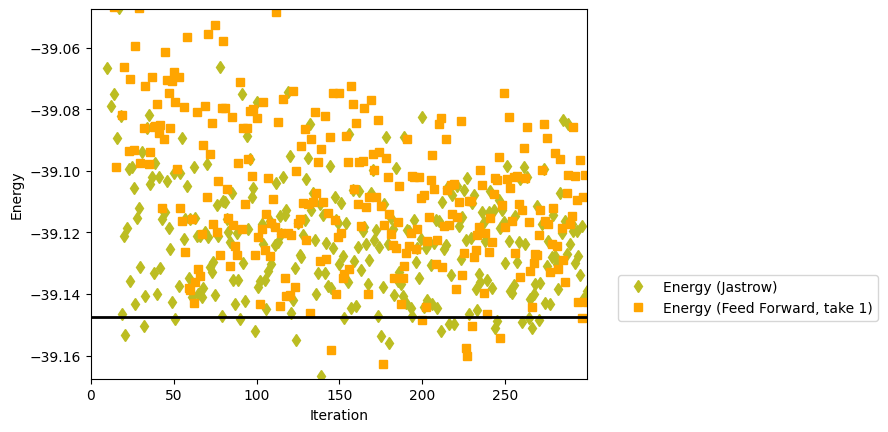

In [19]:
# import the data from log file
data=json.load(open("FF.log"))

# Extract the relevant information
iters_FF = data["Energy"]["iters"]
energy_FF = data["Energy"]["Mean"]["real"]

fig, ax1 = plt.subplots()
ax1.plot(iters_Jastrow, energy_Jastrow, color='C8',linestyle="None", marker='d',label='Energy (Jastrow)')
#ax1.plot(iters_RBM, energy_RBM, color='red', marker='o',linestyle="None",label='Energy (RBM)')
#ax1.plot(iters_symRBM, energy_symRBM, color='blue',linestyle="None",marker='o',label='Energy (Symmetric RBM)')
ax1.plot(iters_FF, energy_FF, color='orange', marker='s',linestyle="None",label='Energy (Feed Forward, take 1)')
ax1.legend(bbox_to_anchor=(1.05, 0.3))
ax1.set_ylabel('Energy')
ax1.set_xlabel('Iteration')
plt.axis([0,iters_FF[-1],exact_gs_energy-0.02,exact_gs_energy+0.1])
plt.axhline(y=exact_gs_energy, xmin=0,
                linewidth=2, color='k', label='Exact')
plt.show()

In [55]:
print(data)

{'Energy': {'iters': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217

In [20]:
class Model2(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=2*x.shape[-1], param_dtype=np.complex128, kernel_init=nn.initializers.normal(stddev=0.1), bias_init=nn.initializers.normal(stddev=0.1))(x)
        x = nk.nn.activation.log_cosh(x)
        x = nn.Dense(features=x.shape[-1], param_dtype=np.complex128, kernel_init=nn.initializers.normal(stddev=0.1), bias_init=nn.initializers.normal(stddev=0.1))(x)
        x = nk.nn.activation.log_cosh(x)
        return jax.numpy.sum(x, axis=-1)
    
ffnn2 = Model2()

# The variational state
vs = nk.vqs.MCState(sa, ffnn, n_samples=1000)

opt = nk.optimizer.Sgd(learning_rate=0.05)

# Stochastic Reconfiguration
sr = nk.optimizer.SR(diag_shift=0.1)

# The ground-state optimization loop
gs = nk.VMC(
    hamiltonian=ha,
    optimizer=op,
    preconditioner=sr,
    variational_state=vs)


start = time.time()
gs.run(out='FF2', n_iter=600)
end = time.time()


print('### Feed Forward (more layers) calculation')
print('Has',vs.n_parameters,'parameters')
print('The Feed Forward (more layers) calculation took',end-start,'seconds')

100%|████████████████████████████| 600/600 [06:05<00:00,  1.64it/s, Energy=-39.145+0.003j ± 0.017 [σ²=0.291, R̂=1.0149]]

### Feed Forward (more layers) calculation
Has 1012 parameters
The Feed Forward (more layers) calculation took 365.76946115493774 seconds


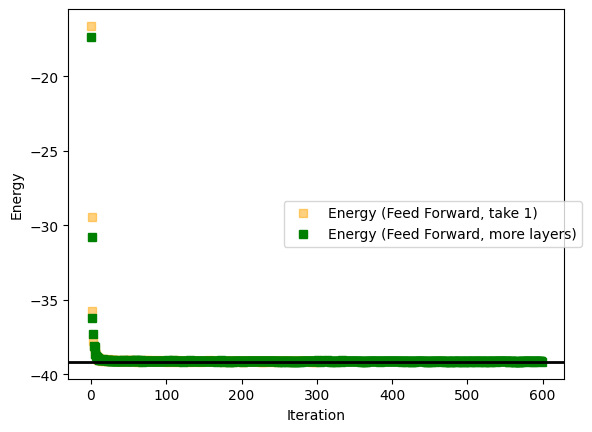

In [21]:
# import the data from log file
data=json.load(open("FF2.log"))

# Extract the relevant information
iters_FF_morelayers = data["Energy"]["iters"]
energy_FF_morelayers = data["Energy"]["Mean"]["real"]

fig, ax1 = plt.subplots()
#ax1.plot(iters_Jastrow, energy_Jastrow, color='C8',linestyle="None", marker='d',label='Energy (Jastrow)')
#ax1.plot(iters_RBM, energy_RBM, color='red', label='Energy (RBM)')
#ax1.plot(iters_symRBM, energy_symRBM, color='blue',linestyle="None",marker='o',label='Energy (Symmetric RBM)')
ax1.plot(iters_FF, energy_FF, color='orange', marker='s',alpha=0.5,linestyle="None",label='Energy (Feed Forward, take 1)')
ax1.plot(iters_FF_morelayers, energy_FF_morelayers, color='green',marker='s',linestyle="None", alpha=1,label='Energy (Feed Forward, more layers)')
ax1.legend(bbox_to_anchor=(1.05, 0.5))
ax1.set_ylabel('Energy')
ax1.set_xlabel('Iteration')
#plt.axis(exact_gs_energy-0.02,exact_gs_energy+0.06)
plt.axhline(y=exact_gs_energy, xmin=0,
               linewidth=2, color='k', label='Exact')
plt.show()

In [22]:
optimizer = nk.optimizer.Genetic(
    n_population=100,
    n_offspring=50,
    selection_method=nk.optimizer.tournament_selection,
    crossover_method=nk.optimizer.single_point_crossover,
)

AttributeError: module 'netket.optimizer' has no attribute 'Genetic'

In [31]:
import pygad as ga

    